# BOXER - Real time automatic creation of bounding boxes and salience maps around detected objects for fixed backgrounds.

**Example Results:**
 - Bounding box creation around a mobile phone

 ![alt text](https://github.com/shreyas-bk/BOXER_auto_annotation_tool/raw/master/phone_annot_ss.jpg)
 - Bounding box creation and salient object higlighting for a mobile phone

 ![alt text](https://github.com/shreyas-bk/BOXER_auto_annotation_tool/raw/master/phone_annot_ss_salient.jpg)

**Features:**
 - *Quick:* No training of the model is required as it only utilizes the feature maps output by the model.
 - *Real-Time:* (Check github for real time scripts with OpenCV). Only a single pass through the model is needed for both bounding box and salient map creation. Since the model is single-layered and lightweight, there is no percievable delay.
 - *Customizable:* Change the hyperparameter values for better results.
 - *Save your results:* Save the images with the bounding box and salient map, along with a text file for the annotaion dimensions.

**STEP 0: Imports and hyperparameters**

Run the following cell for all the necessary imports and to initialize the hyperparameters.

In [1]:
import imutils
import tensorflow.keras as k
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from numpy import expand_dims
import matplotlib.pyplot as plt
import math
import numpy as np
import cv2
from PIL import Image as Img

image_size = (224,224)
kappa, kappa_s = 7, 0
shift = 100
color = (0, 0, 0)
thickness = 2

**STEP 1: Background Capture**

Take a picture of the fixed background.
Note: Salience map highlighting works well when the background is:
 - light colored
 - stable (no moving components like leaves outside a window)
 - uniform (low levels of darker regions are permissible)


<IPython.core.display.Javascript object>

Saved to background.jpg


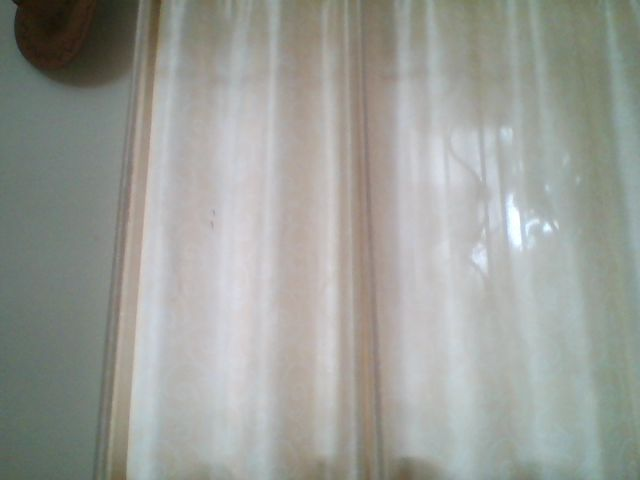

In [2]:
# BACKGROUND PICTURE
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
def take_photo(filename='background.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      await new Promise((resolve) => capture.onclick = resolve);
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  display(Image(filename))
except Exception as err:
  print(str(err))

**STEP 2: Model creation**

Using tensorflow's keras module, create a single layered convolutional layer.
Notes about model:
 - SeparableConv2D layer is used as it is quicker but with similar results. 
 - A depth multiplier can be used to increase the number of output channels.
 - The filter dimension is 1 by 1 to generate a number feature maps, each with a single channel in depth.

In [3]:
model = k.models.Sequential([k.layers.SeparableConv2D(64, (1, 1), activation='relu', input_shape=(image_size[0], image_size[1], 3), depth_multiplier=3)])
output_layer = 0
outputs = [model.layers[output_layer].output]
box_model = Model(inputs=model.inputs, outputs=outputs)
box_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_input (Inpu [(None, 224, 224, 3)]     0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 224, 224, 64)      649       
Total params: 649
Trainable params: 649
Non-trainable params: 0
_________________________________________________________________


**STEP 3: Encode a feature map for the background image**

Generate a number of feature maps (64 in this case) by passing the background image through the model. Average the feature maps to get a single feature map.

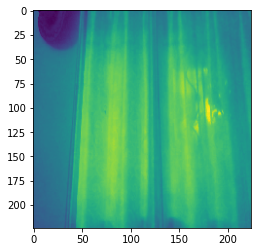

In [4]:
background = load_img('/content/background.jpg', target_size=(image_size))
background_img = img_to_array(background)
background_img = expand_dims(background_img, axis=0)
feature_maps = box_model.predict(background_img)
import matplotlib.pyplot as plt
fmap_back_avg = np.zeros(shape=(feature_maps.shape[1], feature_maps.shape[2]))
span = int(math.sqrt(feature_maps.shape[-1]))
for fmap in feature_maps:
    i = 1
    for _ in range(span):
        for _ in range(span):
            fmap_back_avg += fmap[:, :, i - 1].squeeze()
            i += 1
fmap_back_avg /= (span ** 2)
plt.imshow(fmap_back_avg)

**STEP 4: Take the input image**

<IPython.core.display.Javascript object>

Saved to input.jpg


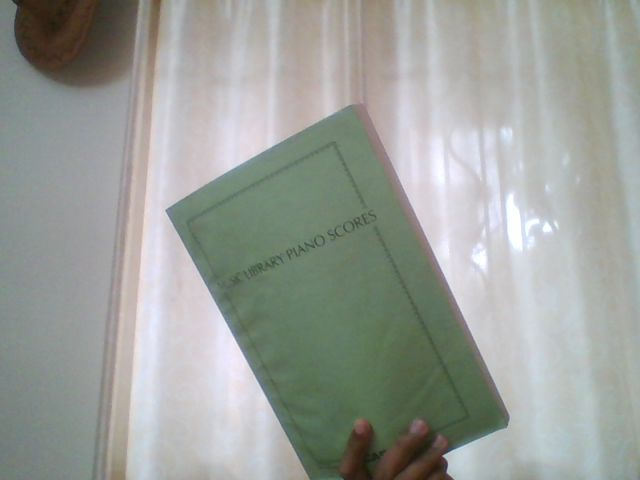

In [5]:
# INPUT PICTURE
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
def take_photo(filename='input.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      await new Promise((resolve) => capture.onclick = resolve);
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  display(Image(filename))
except Exception as err:
  print(str(err))

**STEP 5: Encode and display the results**

If results aren't too good, play around with the kappa and kappa_s values

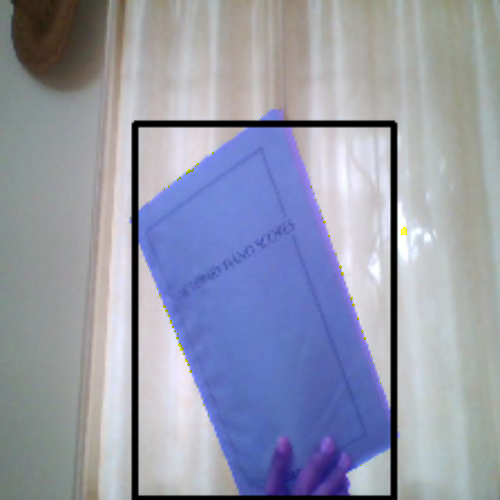

In [6]:
kappa, kappa_s = 7, 0

inp = load_img('/content/input.jpg', target_size=(image_size))
inp = img_to_array(inp)
input_image = expand_dims(inp, axis=0)
feature_maps = box_model.predict(input_image)
fmap_avg = np.zeros(shape=(feature_maps.shape[1], feature_maps.shape[2]))
span = int(math.sqrt(feature_maps.shape[-1]))
for fmap in feature_maps:
  i = 1
  for _ in range(span):
    for _ in range(span):
      fmap_avg += fmap[:, :, i - 1].squeeze()
      i += 1
fmap_avg /= (span ** 2)
diff = fmap_back_avg - fmap_avg
sal_diff = fmap_back_avg - fmap_avg
sal_diff[sal_diff <= kappa_s] = 0
sal_diff[sal_diff > kappa_s] = shift
diff[diff <= kappa] = 0
diff[diff > kappa] = shift
startx, endx, y = [], [], []
count = 0
for i in diff:
  if max(i) != 0:
    y.append(count)
    lis = list(i)
    startx.append(lis.index(shift))
    endx.append(len(lis) - list(reversed(lis)).index(shift) - 1)
  count += 1
startx = np.array(startx)
startx = (startx).astype('int')
endx = np.array(endx)
endx = (endx).astype('int')
y = np.array(y)
y = (y).astype('int')
start, end = (0, 0), (0, 0)
if not (len(startx) == 0 or len(endx) == 0 or len(y) == 0):
  start = (min(startx), max(min(y), 0))
  end = (max(endx), max(y))
  inp[:, :, 2] = inp[:, :, 2] + sal_diff
  cv2.rectangle(inp, start, end, color, thickness)
out = cv2.resize(inp, (500,500))
display(Img.fromarray(out.astype('uint8'), 'RGB'))

**OPTIONAL: Salience map stabilizer**

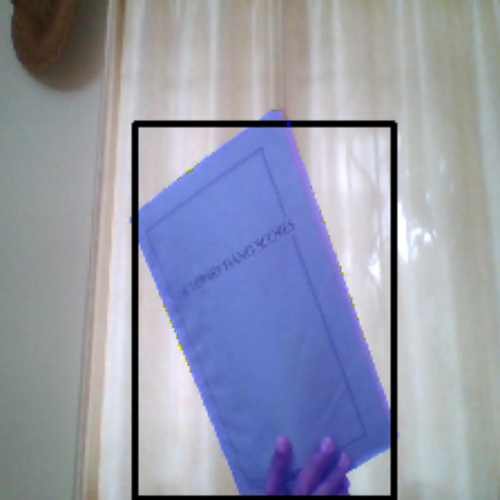

In [7]:
x = fmap_back_avg - fmap_avg
for i in range(223):
  for j in range(223-(1+10+1)):
    lis = np.array([x[i][k] for k in range(j,j+1)])
    lis2 = np.array([x[i][k] for k in range(j+1,j+11)])
    lis3 = np.array([x[i][k] for k in range(j+11,j+12)])
    if all(lis<0) and list(lis2>0).count(True)<5 and all(lis3<0):
      for l in range(j+1,j+11):
        if x[i][l] > 0:
          x[i][l] = 0-x[i][l]
for i in range(223):
  for j in range(223-(1+10+1)):
    lis = np.array([x[i][k] for k in range(j,j+1)])
    lis2 = np.array([x[i][k] for k in range(j+1,j+11)])
    lis3 = np.array([x[i][k] for k in range(j+11,j+12)])
    if all(lis>0) and any(lis2<0) and all(lis3>0):
      for l in range(j+1,j+11):
        if x[i][l] < 0:
          x[i][l] = 0-x[i][l]
x[x <= kappa_s] = 0
x[x > kappa_s] = shift
inp[:, :, 2] = inp[:, :, 2] - sal_diff + x
out = cv2.resize(inp, (500,500))
display(Img.fromarray(out.astype('uint8'), 'RGB'))